# Seminar 2

In this seminar we train different VAD models.

Dataset: https://disk.yandex.ru/d/LJlkc_WMo-libA

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import urllib

import IPython

### Download data

In [10]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from tarfile import TarFile
import tarfile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/LJlkc_WMo-libA'
dst_path = '/home/jupyter/mnt/datasets/dataset_seminar/' # if we make the Datasphere datasets work
dst_path = ''

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# if you aren't in the Datasphere
!wget -O data_sem.tar.gz "{download_url}"
!tar -xf data_sem.tar.gz

# otherwise
# response = requests.get(download_url)
# io_bytes = BytesIO(response.content)
# tar = tarfile.open(fileobj=io_bytes, mode='r:gz')
# tar.extractall(path=dst_path)


--2025-11-15 14:45:04--  https://downloader.disk.yandex.ru/disk/bf277893322b2c2929ce7efe1ff06856aabd34f4f9c5e3d4c2c2522aeb5101aa/6918ca30/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg%3D%3D?uid=0&filename=vad.tar.gz&disposition=attachment&hash=xNl9zyY4MVv885ADo3YdxK0cjYUJpvBOFDMBce1v/nqkkt6F5riqtEefvUDL1r5nq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=24567283&hid=d194eddc3de0a89d9208c5e452965d10&media_type=compressed&tknv=v3
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s1047sas.storage.yandex.net/rdisk/bf277893322b2c2929ce7efe1ff06856aabd34f4f9c5e3d4c2c2522aeb5101aa/6918ca30/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg==?uid=0&filenam

In [16]:
DATADIR = './data'
WAVDIR = os.path.join(DATADIR, 'wav')
ALIGNDIR = os.path.join(DATADIR, 'align')
FS = 16000
FRAME = 30 * FS // 1000
TRAIN = 350
DEVICE = 'cpu'

In [ ]:
class Dataset:
    def __init__(self):
        uttids = [uttid.split('.')[0] for uttid in os.listdir(WAVDIR)]
        self._data = []
        for uttid in uttids:
            wav_path = os.path.join(WAVDIR, f'{uttid}.wav')
            wav, fs = torchaudio.load(wav_path)
            assert fs == FS
            align = np.load(os.path.join(ALIGNDIR, f'{uttid}.npy'))
            while align.shape[0] * FRAME > wav.shape[1]:
                align = align[:-1]
            self._data.append((wav[:, :align.shape[0] * FRAME], align, wav_path))

    def __getitem__(self, idx: int):
        return self._data[idx]
    
    def __len__(self):
        return len(self._data)
    
dataset = Dataset()

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

### Sample

Let's take a look at audiofile, its waveform and its align targets: 

In [18]:
dataset[0][0], dataset[0][1]

(tensor([[ 0.0000e+00,  6.1035e-05,  3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00, -3.0518e-05]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [19]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([1, 150240]), (313,))

In [20]:
IPython.display.Audio(dataset[0][2])

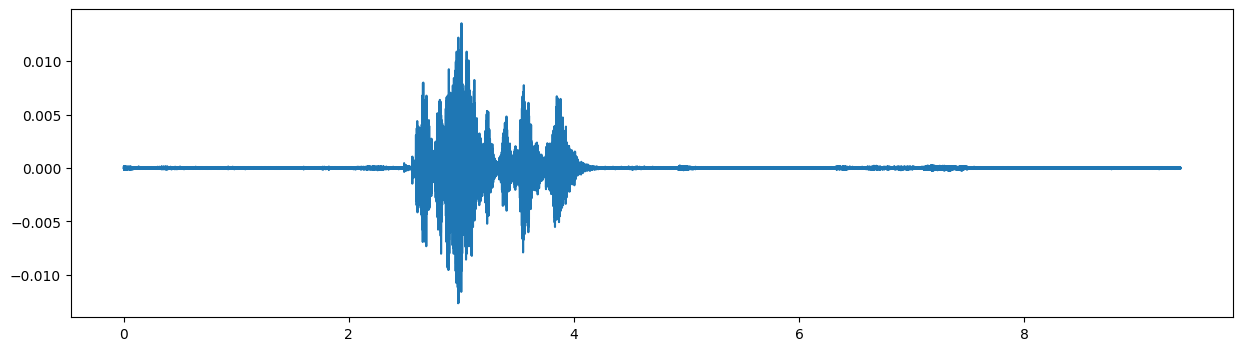

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][0].shape[1] / FS, 1 / FS), dataset[0][0][0])
plt.show()

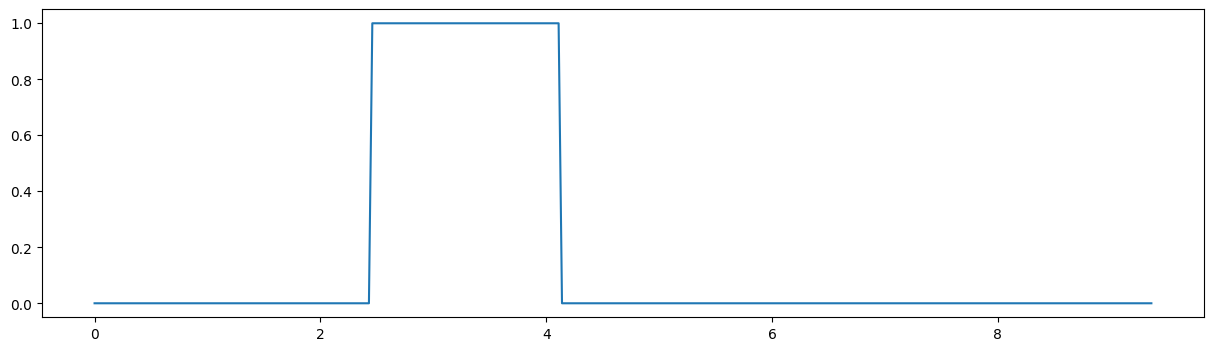

In [22]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][1].shape[0] * 0.03 - 1e-6, 0.03), dataset[0][1])
plt.show()

### Score and Tuning

A large number of metrics can be used for the vad task. Let's try to implement the following:
- Per-frame Accuracy $\frac{\sum_i^N \sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_i^N \sum_j^{A_i} 1}$
- Per-frame Accuracy with utterance normalization $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_j^{A_i} 1}$
- Intersection-over-Union $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij} = 1)}{\sum_j^{A_i} I(A_{ij} = 1 || P_{ij} = 1)}$

where:
- $N$ -- number of utterances
- $A_{ij}$ -- target for $j$-th frame of $i$-th utterance
- $P_{ij}$ -- predict for $j$-th frame of $i$-th utterance

In [23]:
def score(probs: list[np.ndarray], aligns: list[np.ndarray], thr: float = 0.5):
    preds = [prob > thr for prob in probs]
    frame_acc = np.mean(np.concatenate(preds) == np.concatenate(aligns))
    avg_acc = np.mean([np.mean(pred == align) for pred, align in zip(preds, aligns)])
    iou = np.mean([np.sum((pred & align)) / np.sum((pred | align)) for pred, align in zip(preds, aligns)])
    return frame_acc, avg_acc, iou

In [24]:
score([np.array([0.1, 0.2])], [np.array([0, 1])], thr=0.5)

(np.float64(0.5), np.float64(0.5), np.float64(0.0))

Let's write function to find optimal thresholds for per-frame Accuracy metric:

In [28]:
def optimal_thresold(preds, align):
    best_thr, best_acc = 0.0, 0.0
    all_thr = set(*preds)

    for thr in all_thr:
        acc, _, _ = score(preds, align, thr)
        if acc > best_acc:
            best_acc = acc
            best_thr = thr

    return best_thr, best_acc

### Energy VAD

Energy for one frame can be calculated as follows:
$$\frac{1}{N} \sum_i^N x_i^2$$
Where $N$ -- number of amplitudes in frame, $x_i$ -- $i$-th amplitude value.

We can get rid of $\frac{1}{N}$ in this formula, if all frames has the same size.

In [29]:
Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
X = np.array(np.split(np.concatenate([item[0][0] for item in dataset[:TRAIN]]), Y.shape[0]))
Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
X_test = np.array(np.split(np.concatenate([item[0][0] for item in dataset[TRAIN:]]), Y_test.shape[0]))
parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
train_preds = np.mean(X*X, axis=1)
thr, train_acc = optimal_thresold([train_preds], [Y])
test_preds = np.mean(X_test*X_test, axis=1)
test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
print(train_acc, test_score)

0.8979495081189997 (np.float64(0.9113445191152254), np.float64(0.8997264302478624), np.float64(0.6853660388475706))


### Linear VAD

Let's try to use simple binary classification model for each frame.

In [35]:
def frame_classification(transform: nn.Module):
    X = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[:TRAIN]])
    Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
    X_test = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[TRAIN:]])
    Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
    parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
    model = LogisticRegression(max_iter=1000)
    model.fit(X, Y)
    train_preds = model.predict_proba(X)[:, 1]
    test_preds = model.predict_proba(X_test)[:, 1]
    thr, train_acc = optimal_thresold([train_preds], [Y])
    test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
    print(train_acc, test_score)

In [33]:
frame_classification(torchaudio.transforms.MelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23))

0.8994903401683063 (np.float64(0.9131247496550803), np.float64(0.8999849812942228), np.float64(0.6777567382714864))


In [36]:
frame_classification(
    torchaudio.transforms.MFCC(n_mfcc=13, melkwargs={'n_mels': 23, 'n_fft': FRAME, 'hop_length': FRAME})
)

0.9085575441507645 (np.float64(0.9217588677733767), np.float64(0.9108156747069666), np.float64(0.7171856118140393))


### NN VAD

This is an unscored exercise, we are going to look at the homework instead

Let's try to aggregate adjacent frames:

In [56]:
def multiframe_classification(transform: nn.Module, model: nn.Module):
    ...
    print(train_acc, test_score)

In [73]:
multiframe_classification(
    torchaudio.transforms.MelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23),
    nn.Sequential(nn.Conv1d(23, 23, 5, padding=2), nn.ReLU(), nn.Conv1d(23, 1, 1), nn.Sigmoid())
)

In [74]:
multiframe_classification(
    torchaudio.transforms.MFCC(n_mfcc=13, melkwargs={'n_mels': 23, 'n_fft': FRAME, 'hop_length': FRAME}),
    nn.Sequential(nn.Conv1d(13, 23, 5, padding=2), nn.ReLU(), nn.Conv1d(23, 1, 1), nn.Sigmoid())
)

### Check model errors

Let's try to get some previous model and use it to make prediction.
After that, let's look at the utterances with the worst score.

In [135]:
...